# Ejercicio aplicado_Machine Learning con Spark

En este notebook entrenaremos un modelo de clasificacion binaria capaz de predecir la enfermedad cardiaca en base a diferentes mediciones de parametros bioquimicos. Para ello utilizaremos el dataset de Kaggle

#### Ejercicio 1

En este ejercicio vamos a importar y
preprocesar los datos de 'data/heart.csv' que
utilizaremos para entrenar un modelo de clasificación binaria con PySpark . Para ello,
tendrás que inicializar una sesión de Spark , cargar los datos con el esquema correcto y
analizar su distribución.
Es
decir, debes completar la parte de importación y análisis exploratorio de los datos.

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('UCI Heart disease').getOrCreate()

In [4]:
from pyspark.ml.classification import LogisticRegression

In [5]:
heart = spark.read.csv('heart.csv', 
                       inferSchema = True, 
                       header = True)

In [6]:
heart.show(10)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|
| 57|  1|  0|     140| 192|  0|      1|    148|    0|    0.4|    1|  0|   1|     1|
| 56|  0|  1|     140| 294|  0|      0|    153|    0|    1.3|    1|  0|   2|     1|
| 44|  1|  1|     120| 263|  0|      1|    173|    0|    0.0|    2|  0|   3|     1|
| 52|  1|  2|     172| 199|  1|      1|    162|    0|    0.5|    2|  0|   3|

In [12]:
heart_pd = heart.toPandas()

heart_pd.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [8]:
heart.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



#### 1.1 Análisis exploratorio 

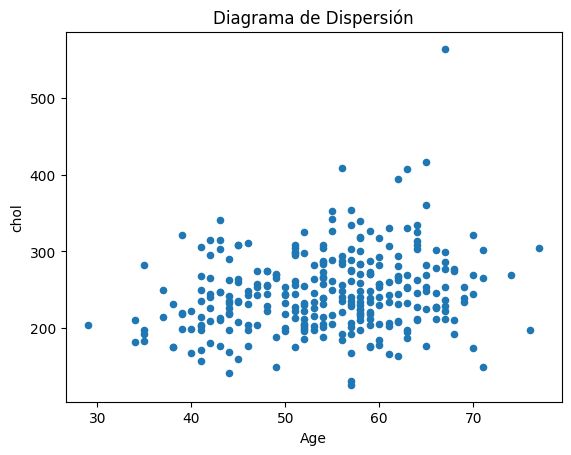

In [14]:
import matplotlib.pyplot as plt

heart_pd.plot.scatter(x='age', y='chol')

# Agregar etiquetas y título
plt.xlabel('Age')
plt.ylabel('chol')
plt.title('Diagrama de Dispersión')

# Mostrar el gráfico
plt.show()

##### Analítica

El diagrama de dispersión anterior muestra cómo se distribuyen los puntos en el rango de edad del os 30 a los 70 años.

Se puede concluir que muestran un aglutinamiento entre 200 chol y 55 años.

In [16]:
heart.describe().toPandas()

,summary,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,count,303,303,303,303,303,303,303,303,303,303,303,303,303,303
1,mean,54.366336633663366,0.6831683168316832,0.966996699669967,131.62376237623764,246.26402640264027,0.1485148514851485,0.528052805280528,149.64686468646866,0.32673267326732675,1.0396039603960396,1.3993399339933994,0.7293729372937293,2.3135313531353137,0.5445544554455446
2,stddev,9.08210098983786,0.46601082333962385,1.0320524894832983,17.5381428135171,51.83075098793005,0.35619787492797644,0.525859596359298,22.90516111491409,0.46979446452231655,1.1610750220686346,0.6162261453459622,1.0226063649693276,0.6122765072781408,0.4988347841643915
3,min,29,0,0,94,126,0,0,71,0,0.0,0,0,0,0
4,max,77,1,3,200,564,1,2,202,1,6.2,2,4,3,1


### 2. Preprocesamiento de datos

In [17]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [18]:
heart.columns

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'target']

In [19]:
assembler = VectorAssembler(
                            inputCols=['age',
                            'sex',
                            'cp',
                            'trestbps',
                            'chol',
                            'fbs',
                            'restecg',
                            'thalach',
                            'exang',
                            'oldpeak',
                            'slope',
                            'ca',
                            'thal'],
                            outputCol="features")

In [20]:
output = assembler.transform(heart)

In [21]:
output.show(5)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+--------------------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|            features|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+--------------------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|[63.0,1.0,3.0,145...|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|[37.0,1.0,2.0,130...|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|[41.0,0.0,1.0,130...|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|[56.0,1.0,1.0,120...|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|[57.0,0.0,0.0,120...|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+--------------------+
only showing top 5 rows



In [22]:
final_data = output.select("features",'target')

### 3. Entrenamiento del modelo

In [23]:
train, test = final_data.randomSplit([0.7,0.3])

In [24]:
lr = LogisticRegression(labelCol="target",
                        featuresCol="features")

In [25]:
model = lr.fit(train)

In [26]:
predict_train=model.transform(train)
predict_test=model.transform(test)
predict_test.select("target","prediction").show(10)

+------+----------+
|target|prediction|
+------+----------+
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+
only showing top 10 rows



### 3.1 Evaluación del modelo

In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',
                                          labelCol='target')

predict_test.select("target","rawPrediction","prediction","probability").show(5)


+------+--------------------+----------+--------------------+
|target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     1|[-0.8051172181574...|       1.0|[0.30893196176716...|
|     1|[-5.6973794358228...|       1.0|[0.00334352858697...|
|     1|[-4.6319050843688...|       1.0|[0.00964231372484...|
|     1|[-0.8733236728541...|       1.0|[0.29456318576234...|
|     1|[-2.1766723567663...|       1.0|[0.10186496588198...|
+------+--------------------+----------+--------------------+
only showing top 5 rows



In [28]:
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))

print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set is 0.9307285307285308
The area under ROC for test set is 0.9021464646464646


### Conclusión ###


Con los resultados obtenidos se concluye que se cuenta con un buen modelo con el 90% de eficiencia y que puede servir para predecir valores futuros.